In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [4]:
def crop_black(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    x_nonzero = np.nonzero(gray[0])
    y_nonzero = np.nonzero(gray[:, gray.shape[1]-1])
    return img[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):]

In [3]:
def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  list_of_points_2 = cv.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min, -y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

In [25]:
def concat_images(img1, img2, method):
    orb = cv.ORB_create(nfeatures=2000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    all_matches = []
    for m, n in matches:
        all_matches.append(m)

    good = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good.append(m)
            
    MIN_MATCH_COUNT = 10

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        result = method(img1, img2, M)

        result = crop_black(result)
        
        return result
        
    return None

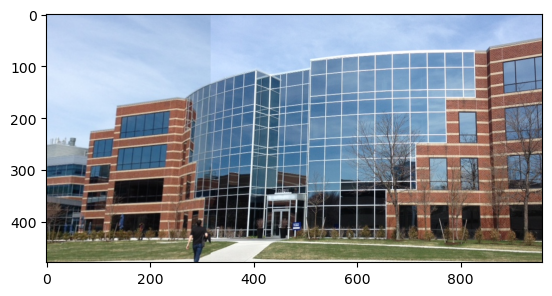

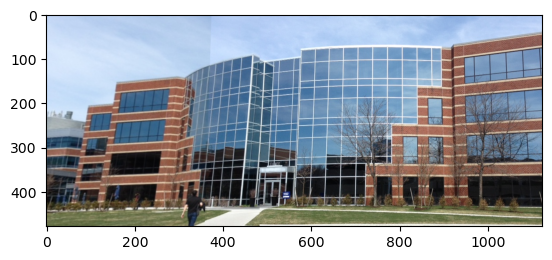

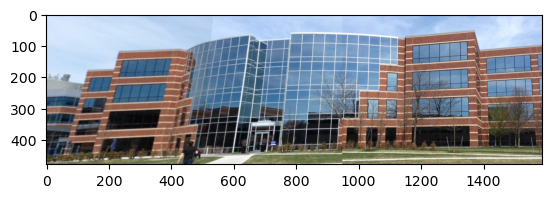

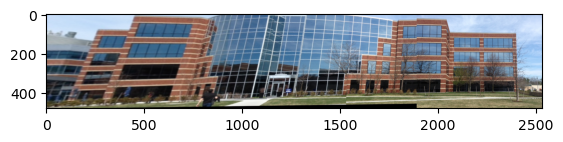

In [31]:
p = pathlib.Path('./building')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

for img_path in it:
    img2 = cv.imread(str(img_path))
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    
    img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages(i2, i1, M))
       
    if img1 is None:
        print("Not enought match keypoints")
        break
    
    plt.imshow(img1)
    plt.show()

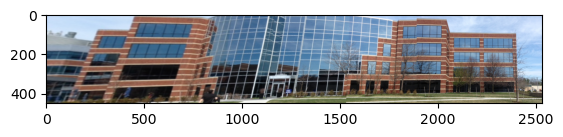

In [47]:
result = img1[:450]

plt.imshow(result)